# Numerical Differentiation and Integration

**ScPo Computational Economics 2017**

## Derivatives

1. Finite Differencing: a numerical approximation
	* Based on Taylor's Theorem
	* Observe variation in function values from evaluating it at "close" points.
	* Forward Differencing and Central Differencing
2. Automatic Differentiation
	* Breaks down the actual `code` that defines a function and performs elementary differentiation rules, after disecting expressions via the chain rule.
	* This produces **analytic** derivatives, i.e. there is **no** approximation error.
	* This is the future.
3. Symbolic Differentiation
	* Some languages (most notably Mathematica) support symbolic algebra. Very useful sometimes if one needs to work through complicated expressions.
	* Not very useful for high computational demands, i.e. repeated computation of derivatives in an optimization routine.


## Finite Differences

* Consider the definition of the derivative of $f$ at point $x$:
	$$ f'(x) = \lim_{h\to0}\frac{f(x+h)-f(x)}{h} $$
* The simplest way to calculate a numerical derivative is to replicate this computation for small $h$ with:
	$$ f'(x) \approx \frac{f(x+h)-f(x)}{h},\quad h\text{ small.} $$
* This is known as the Forward Difference approach.
* There are different approaches, e.g. the central difference approach does
	$$ f'(x) \approx \frac{f(x+h)-f(x-h)}{2h},\quad h\text{ small.} $$
* How does this perform?

In [ ]:
using Gadfly
f(x) = 2 - x^2
c = -0.75
sec_line(h) = x -> f(c) + (f(c + h) - f(c))/h * (x - c)
plot([f, sec_line(1), sec_line(.5), sec_line(.25), sec_line(.05)], -1, 1)

* What's the problem? Well, what is *small*?  


### Finite Differences: what's the right step size $h$?

* Theoretically, we would like to have $h$ as small as possible, since we want to approximate the limit at zero.
* In practice, on a computer, there is a limit to this. There is a smallest representable number, as we know.
* `eps()`.
* One can show that the optimal step size is $h=\sqrt{\texttt{eps()}}$

## Automatic Differentiation (AD)

* 2 modes: Forward and Reverse Mode.
* The basic idea is that the derivative of any function can be decomposed into some basic algebraic operations.
* The [wikipedia page is informative](https://en.wikipedia.org/wiki/Automatic_differentiation)

![[By Berland at en.wikipedia [Public domain], from Wikimedia Commons](https://commons.wikimedia.org/wiki/File%3AAutomaticDifferentiation.png)](assets/figs/integration/wikipedia-AD.png)

## Example

* Suppose we want to differentiate $f(x_1,x_2) = x_1 x_2 + \sin x_1$
* We label subexpressions by $w_i$ as follows:
	$$ \begin{array}{cl}
	f(x_1,x_2) &= x_1 x_2 + \sin x_1 \\
	&= w_1 w_2 + sin w_1 \\
	&= w_3  + w_4 \\
	&= w_5 
	\end{array} 
	$$
* Computation of the partial derivative starts with the seed value, i.e. $\dot{w}_1 = \frac{\partial x_1}{\partial x_1} = 1$.
* We store for each subexpression both the value and the derivative, i.e. $(w_i,\dot{w}_i)$
* We then sweep through the expression tree as in this picture:

![[By Berland at en.wikipedia [Public domain], from Wikimedia Commons](https://commons.wikimedia.org/wiki/File%3AForwardAccumulationAutomaticDifferentiation.png)](assets/figs/integration/wikipedia-AD-example.png)


## AD in Julia

* The organisation here is [http://www.juliadiff.org](http://www.juliadiff.org)
* There are many packages to perform differentiation with Julia here.
* Many packages rely on the machinery here. 
* Let's quickly look at [https://github.com/JuliaDiff/ForwardDiff.jl](https://github.com/JuliaDiff/ForwardDiff.jl)

In [9]:
# from ForwardDiff's readme:
using ForwardDiff
f(x::Vector) = sum(sin, x) + prod(tan, x) * sum(sqrt, x);
x = rand(5) # small size for example's sake
g = x -> ForwardDiff.gradient(f, x); # g = ∇f
g(x)
ForwardDiff.hessian(f, x)

5×5 Array{Float64,2}:
 16.5617  17.7202   14.9343  15.7436  15.8804
 17.7202   9.93862  17.5614  18.514   18.6732
 14.9343  17.5614   15.338   15.6029  15.7381
 15.7436  18.514    15.6029  20.6457  16.5919
 15.8804  18.6732   15.7381  16.5919  10.7502

* The authors provide some benchmarks. Let's run those:

```julia
include(joinpath(Pkg.dir("ForwardDiff"),"benchmark","ForwardDiffBenchmarks.jl"))
```

## Numerical Approximation of Integrals

* We will focus on methods that represent integrals as weighted sums.
* The typical representation will look like:
	$$ E[G(\epsilon)] = \int_{\mathbb{R}^N} G(\epsilon) w(\epsilon) d\epsilon \approx \sum_{j=1}^J \omega_j G(\epsilon_j) $$

$$ E[G(\epsilon)] = \int_{\mathbb{R}^N} G(\epsilon) w(\epsilon) d\epsilon \approx \sum_{j=1}^J \omega_j G(\epsilon_j) $$

* $N$ is the dimensionality of the integration problem.
* $G:\mathbb{R}^N \mapsto \mathbb{R}$ is the function we want to integrate wrt $\epsilon \in \mathbb{R}^N$.
* $w$ is a density function s.t. $\int_{\mathbb{R}^n} w(\epsilon) d\epsilon = 1$.
* $\omega$ are weights such that (most of the time) $\sum_{j=1}^J \omega_j = 1$.
* We will look at normal shocks $\epsilon \sim N(0_N,I_N)$
* in that case, $w(\epsilon) = (2\pi)^{-N/2} \exp \left(-\frac{1}{2}\epsilon^T \epsilon \right)$
* $I_N$ is the n by n identity matrix, i.e. there is no correlation among the shocks for now.
* Other random processes will require different weighting functions, but the principle is identical.
* For now, let's say that $N=1$



## Quadrature Rules

* We focus exclusively on those and leave Simpson and Newton Cowtes formulas out.
	* This is because Quadrature is the method that in many situations gives highes accuracy with lowest computational cost.
* Quadrature provides a rule to compute weights $w_j$ and nodes $\epsilon_j$.
* There are many different quadrature rules.
* They differ in their domain and weighting function.
* [https://en.wikipedia.org/wiki/Gaussian_quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature)
* In general, we can convert our function domain to a rule-specific domain with change of variables.



## Gauss-Hermite: Expectation of a Normally Distributed Variable

* There are many different rules, all specific to a certain random process.
* Gauss-Hermite is designed for an integral of the form
	$$ \int_{-\infty}^{+\infty} e^{-x^2} G(x) dx $$
	and where we would approximate 
	$$ \int_{-\infty}^{+\infty} e^{-x^2} f(x) dx \approx \sum_{i=1}^n \omega_i G(x_i) $$
* Now, let's say we want to approximate the expected value of function $f$ when it's argument $z\sim N(\mu,\sigma^2)$:
	$$ E[f(z)] = \int_{-\infty}^{+\infty} \frac{1}{\sigma \sqrt{2\pi}} \exp \left( -\frac{(z-\mu)^2}{2\sigma^2} \right) f(z) dz $$




## Gauss-Hermite: Expectation of a Normally Distributed Variable

* The rule is defined for $x$ however. We need to transform $z$:
	$$ x = \frac{(z-\mu)^2}{2\sigma^2} \Rightarrow z = \sqrt{2} \sigma x + \mu $$
* This gives us now (just plug in for $z$)
	$$ E[f(z)] = \int_{-\infty}^{+\infty} \frac{1}{ \sqrt{\pi}} \exp \left( -x^2 \right) f(\sqrt{2} \sigma x + \mu) dx $$
* And thus, our approximation to this, using weights $\omega_i$ and nodes $x_i$ is
	$$ E[f(z)] \approx \sum_{j=1}^J \frac{1}{\sqrt{\pi}} \omega_j f(\sqrt{2} \sigma x_j + \mu)$$



## Using Quadrature in Julia

* [https://github.com/ajt60gaibb/FastGaussQuadrature.jl](https://github.com/ajt60gaibb/FastGaussQuadrature.jl)

In [8]:
#Pkg.add("FastGaussQuadrature")

using FastGaussQuadrature

np = 3

rules = Dict("hermite" => gausshermite(np),
             "chebyshev" => gausschebyshev(np),
             "legendre" => gausslegendre(np),
             "lobatto" => gausslobatto(np))


using DataFrames

integ = DataFrame(Rule=Symbol[symbol(x) for x in keys(rules)],nodes=[x[1] for x in values(rules)],weights=[x[2] for x in values(rules)])

,Rule,nodes,weights
1,lobatto,"[-1.0,0.0,1.0]","[0.333333,1.33333,0.333333]"
2,hermite,"[-1.22474,-8.88178e-16,1.22474]","[0.295409,1.18164,0.295409]"
3,legendre,"[-0.774597,0.0,0.774597]","[0.555556,0.888889,0.555556]"
4,chebyshev,"[-0.866025,6.12323e-17,0.866025]","[1.0472,1.0472,1.0472]"


## Quadrature in more dimensions: Product Rule

* If we have $N>1$, we can use the product rule: this just takes the kronecker product of all univariate rules.
* This works well as long as $N$ is not too large. The number of required function evaluations grows exponentially.
	$$ E[G(\epsilon)] = \int_{\mathbb{R}^N} G(\epsilon) w(\epsilon) d\epsilon \approx \sum_{j_1=1}^{J_1} \cdots \sum_{j_N=1}^{J_N} \omega_{j_1}^1 \cdots \omega_{j_N}^N G(\epsilon_{j_1}^1,\dots,\epsilon_{j_N}^N) $$
	where $\omega_{j_1}^1$ stands for weight index $j_1$ in dimension 1, same for $\epsilon$.
* Total number of nodes: $J=J_1 J_2 \cdots J_N$, and $J_i$ can differ from $J_k$.


### Example for $N=3$

* Suppose we have $\epsilon^i \sim N(0,1),i=1,2,3$ as three uncorrelated random variables.
* Let's take $J=3$ points in all dimensions, so that in total we have $J^N=27$ points.
* We have the nodes and weights from before in `rules["hermite"]`.

In [6]:
nodes = Any[]
push!(nodes,repeat(rules["hermite"][1],inner=[1],outer=[9]))
push!(nodes,repeat(rules["hermite"][1],inner=[3],outer=[3]))
push!(nodes,repeat(rules["hermite"][1],inner=[9],outer=[1]))
weights = kron(rules["hermite"][2],kron(rules["hermite"][2],rules["hermite"][2]))
df = hcat(DataFrame(weights=weights),DataFrame(nodes,[:dim1,:dim2,:dim3]))

,weights,dim1,dim2,dim3
1,0.02577929628162838,-1.2247448713915892,-1.2247448713915892,-1.2247448713915892
2,0.10311718512651327,-8.881784197001252e-16,-1.2247448713915892,-1.2247448713915892
3,0.02577929628162838,1.2247448713915892,-1.2247448713915892,-1.2247448713915892
4,0.10311718512651327,-1.2247448713915892,-8.881784197001252e-16,-1.2247448713915892
5,0.41246874050605215,-8.881784197001252e-16,-8.881784197001252e-16,-1.2247448713915892
6,0.10311718512651327,1.2247448713915892,-8.881784197001252e-16,-1.2247448713915892
7,0.02577929628162838,-1.2247448713915892,1.2247448713915892,-1.2247448713915892
8,0.10311718512651327,-8.881784197001252e-16,1.2247448713915892,-1.2247448713915892
9,0.02577929628162838,1.2247448713915892,1.2247448713915892,-1.2247448713915892
10,0.10311718512651327,-1.2247448713915892,-1.2247448713915892,-8.881784197001252e-16


* Imagine you had a function $g$ defined on those 3 dims: in order to approximate the integral, you would have to evaluate $g$ at all combinations of `dimx`, multiply with the corresponding weight, and sum.


### Alternatives to the Product Rule

* Monomial Rules: They grow only linearly.
* Please refer to [@judd-book] for more details.




## Monte Carlo Integration

* A widely used method is to just draw $N$ points randomly from the space of the shock $\epsilon$, and to assign equal weights $\omega_j=\frac{1}{N}$ to all of them.
* The expectation is then
	$$ E[G(\epsilon)] \approx \frac{1}{N} \sum_{j=1}^N  G(\epsilon_j) $$
* This in general a very inefficient method.
* Particularly in more than 1 dimensions, the number of points needed for good accuracy is very large.

## Quasi Monte Carlo Integration

* Uses non-product techniques to construct a grid of uniformly spaced points.
* The researcher controlls the number of points. 
* We need to construct equidistributed points.
* Typically one uses a low-discrepancy sequence of points, e.g. the Weyl sequence:
* $x_n = {n v}$ where $v$ is an irrational number and `{}` stands for the fractional part of a number. for $v=\sqrt{2}$,
	$$ x_1 = \{1 \sqrt{2}\} = \{1.4142\} = 0.4142, x_2 = \{2 \sqrt{2}\} = \{2.8242\} = 0.8242,... $$
* Other low-discrepancy sequences are Niederreiter, Haber, Baker or Sobol.

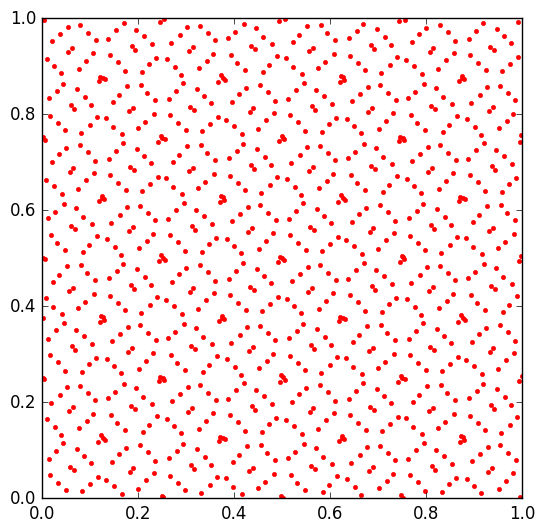

INFO: No packages to install, update or remove
INFO: Package database updated
INFO: METADATA is out-of-date — you may not have the latest version of Sobol
INFO: Use `Pkg.update()` to get the latest versions of your packages


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x323fb92d0>

In [2]:
# Pkg.add("Sobol")
using Sobol
using PyPlot
s = SobolSeq(2)
p = hcat([next(s) for i = 1:1024]...)'
subplot(111, aspect="equal")
plot(p[:,1], p[:,2], "r.")

 ## Correlated Shocks

* We often face situations where the shocks are in fact correlated.
	* One very typical case is an AR1 process:
	$$ z_{t+1} = \rho z_t + \varepsilon_t, \varepsilon \sim N(0,\sigma^2) $$
* The general case is again:
	$$ E[G(\epsilon)] = \int_{\mathbb{R}^N} G(\epsilon) w(\epsilon) d\epsilon \approx \sum_{j_1=1}^{J_1} \cdots \sum_{j_N=1}^{J_N} \omega_{j_1}^1 \cdots \omega_{j_N}^N G(\epsilon_{j_1}^1,\dots,\epsilon_{j_N}^N) $$

* Now $\epsilon \sim N(\mu,\Sigma)$ where $\Sigma$ is an N by N variance-covariance matrix.
* The multivariate density is
	$$w(\epsilon) = (2\pi)^{-N/2} det(\Sigma)^{-1/2} \exp \left(-\frac{1}{2}(\epsilon - \mu)^T (\epsilon - \mu) \right)$$
* We need to perform a change of variables before we can integrate this.
* Given $\Sigma$ is symmetric and positive semi-definite, it has a Cholesky decomposition, 
	$$ \Sigma = \Omega \Omega^T $$
	where $\Omega$ is a lower-triangular with strictly positive entries.
* The linear change of variables is then
	$$ v = \Omega^{-1} (\epsilon - \mu)  $$



* Plugging this in gives
	$$ \sum_{j=1}^J \omega_j  G(\Omega v_j + \mu) \equiv \sum_{j=1}^J \omega_j  G(\epsilon_j) $$
	where $v\sim N(0,I_N)$.
* So, we can follow the exact same steps as with the uncorrelated shocks, but need to adapt the nodes.








## References

* The Integration part of these slides are based on [@maliar-maliar] chapter 5